In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9,10])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new
from helpers import rl_covmat_ests_for_dataset as estimators



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\traitlets\con

In [2]:
def get_new_eigenvalues(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    if qis_eigenvalues.shape[0] == 500:
        intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    else:
        intensity = qis_eigenvalues / sample_eigenvalues
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    if qis_eigenvalues.shape[0] == 500:
        qis_evs_new.iloc[: , 0:250] = intensity_of_intensity * qis_eigenvalues.iloc[: , 0:250]

    # get Rotation Points
    intens_df = qis_eigenvalues / sample_eigenvalues
    if qis_eigenvalues.shape[1] == 500:  # only 1 year case ofcourse
        intens_df = intens_df.fillna(0)
    right_rotation_idx = np.argmin( np.abs(intens_df-1) , axis=1)
    left_rotation_idx = right_rotation_idx - 1
    rotation_point_sample_evs = 0.5 * np.diag(sample_eigenvalues.iloc[:, left_rotation_idx]) + 0.5 * np.diag(sample_eigenvalues.iloc[:, right_rotation_idx])
    rotation_points = 0.5 * np.diag(intens_df.iloc[:, left_rotation_idx]) + 0.5 * np.diag(intens_df.iloc[:, right_rotation_idx])
    rotation_points = rotation_points * rotation_point_sample_evs

    # Force all eigenvalues to be in decreasing order (from the largest one)
    idx_is_increasing = qis_evs_new.diff(axis=1).fillna(0) < 0
    qis_evs_new[idx_is_increasing] = np.nan
    qis_evs_new = qis_evs_new.bfill(axis=1)

    # check if values left (right) of rotation point are smaller (larger) than rotation point
    # check: is idx < left and value_at_idx > value_at_left --> then np.nan and ffill it for left (and bfill for right)
    for i in range(qis_evs_new.shape[0]):
        tmp = qis_evs_new.iloc[i, :].copy()
        left_bool = tmp[0:left_rotation_idx[i]] > rotation_points[i]
        right_bool = tmp[left_rotation_idx[i]:] < rotation_points[i]
        # change those evs on right that are smaller than rotation point
        tmp_right = tmp[left_rotation_idx[i]:]
        tmp_right[right_bool] = np.nan
        tmp_right.bfill(inplace=True) 
        tmp_right.ffill(inplace=True)  # in case the largest ev is NAN, we need to additionally ffill
        # change those evs on left that are LARGER than rotation point
        tmp_left = tmp[0:left_rotation_idx[i]]
        tmp_left[left_bool] = np.nan
        tmp_left.ffill(inplace=True) 
        tmp_left.bfill(inplace=True) # in case the smallest ev is NAN, we need to additionally bfill
        tmp_left.fillna(rotation_points[i], inplace=True)  # in case all eigenvalues left of rotation point are larger than rotation point
        # change qis_evs_new row
        qis_evs_new.iloc[i, :] = np.concatenate([tmp_left, tmp_right])

    # a few correction checks
    assert any(qis_evs_new.diff(axis=1).fillna(0) < 0), "Eigenvalues are not monotonically decreasing!"
    assert any(qis_evs_new.isna()), "There are NaN's in the QIS Eigenvalue Matrix!"
 
    return qis_evs_new

In [3]:
# LOAD EIGENVALUES
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)


qis_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\qis_evs_df_p{PF_SIZE}.csv", index_col=0)
sample_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\sample_evs_df_p{PF_SIZE}.csv", index_col=0)

In [4]:
intensity_of_intensity_list = np.arange(0.5, 2.01, 0.05).round(2)
ioi_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
all_res = pd.read_csv(ioi_path + f"\\all_res_p{PF_SIZE}_v2.csv", index_col=0)
all_rawres = pd.read_csv(ioi_path + f"\\all_rawres_p{PF_SIZE}_v2.csv", index_col=0)

allres_min_idxes_full = all_res.idxmin(axis=1)[: -21].values
allres_min_idxes_full = np.insert(allres_min_idxes_full, 0, np.repeat(["1.0"], 21))

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = all_res.idxmin(axis=1).values
allres_min_idxes_BIASED = allres_min_idxes_BIASED


# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [5]:
all_factors = intensity_of_intensity_list
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))

opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

opt_v4 = np.copy(opt_v3)
opt_v4 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))[:-21]

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values

In [6]:
qis_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\qis_evs_df_p{PF_SIZE}.csv", index_col=0)
sample_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\sample_evs_df_p{PF_SIZE}.csv", index_col=0)

top10_quot = qis_evs.iloc[:, -10:].mean(axis=1) / sample_evs.iloc[:, -10:].mean(axis=1)
quot2 = top10_quot = qis_evs.iloc[:, -50:-10].mean(axis=1) / sample_evs.iloc[:, -50:-10].mean(axis=1)

In [7]:
def eval_model_outputs(res, intensity_of_intensity_list, show_fig=True):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)
    Y_eval = all_rawres
    Y_eval.columns = Y_eval.columns.astype(str)
    res_evaluated2 = re_hf.evaluate_all_factor_preds(res, Y_eval, len_train)
    datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
    res_df = pd.DataFrame(np.array(res, dtype=float), index=datetime_index[5040:], columns=[""])
    
    fig = px.line(res_df, height=500, width=1000).update_layout(
        xaxis_title="Year", yaxis_title="Intensity of Intensity")
    
    print("Result:", res_evaluated2)
    if show_fig:
        fig.show()

    return fig

In [8]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2]
}

X = re_hf.load_additional_train_data(**params)

In [9]:
## test base

res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040)
fig = eval_model_outputs(res, intensity_of_intensity_list, show_fig=True)

Result: (np.float64(9.395), np.float64(10.363))


### Cross Validation

In [10]:
from sklearn.linear_model import ElasticNet
def general_single_output_ElasticNet_Lagged_CrossValidation(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = ElasticNet(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = np.round(preds, 0)
            model_predictions.append(preds)


def eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)

    Y_eval = all_rawres.iloc[len_cv_train:len_train]

    returns = np.diag(Y_eval.loc[:, res])
    returns_sd = returns.std() * np.sqrt(252) * 100
    returns_means = returns.mean() * 252 * 100

    return returns_means, returns_sd

In [11]:
len_cv_train = int(len_train*0.8) 

train_x_cv = X[:len_cv_train]
train_y_cv = Y[:len_cv_train]

val_x = X[len_cv_train:len_train]
val_y = Y[len_cv_train:len_train]

In [19]:
%%capture

from sklearn.model_selection import ParameterGrid
model_params_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
    "max_iter": [500, 1000, 1500, 2000],
    "tol": [1e-3, 1e-4, 1e-5]
}
model_params_grid = list(ParameterGrid(model_params_grid))

sds = []
for p in model_params_grid:
    res = general_single_output_ElasticNet_Lagged_CrossValidation(X=X[:len_train], Y=Y[:len_train], len_train=len_cv_train, model_params=p)
    AV, SD = eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train)
    sds.append(SD.round(3))

### Evaluate OOS Results

In [20]:
np.argmin(sds)
p_best = model_params_grid[np.argmin(sds)]
res = general_single_output_ElasticNet_Lagged_CrossValidation(X=X, Y=Y, len_train=len_train, model_params=p_best)
#fig = eval_model_outputs(res, intensity_of_intensity_list, show_fig=True)

In [22]:
p_best

{'alpha': 5.0,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 2000,
 'tol': 0.001}

np.float64(10.375913300766511)

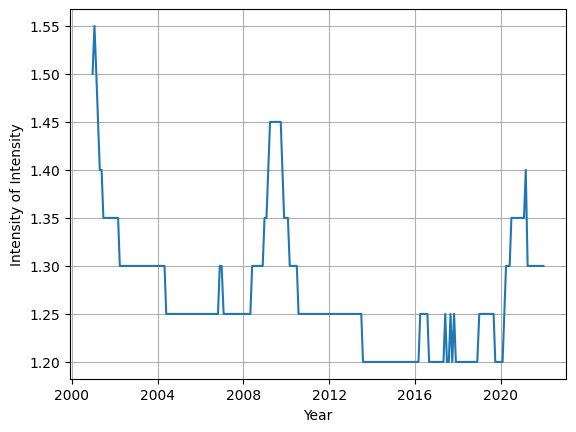

In [21]:
mapped_res = re_hf.map_preds_to_factors(res, all_factors)
Y_eval = all_rawres
Y_eval.columns = Y_eval.columns.astype(str)
res_evaluated2 = re_hf.evaluate_all_factor_preds(mapped_res, Y_eval, len_train)
datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
res_df = pd.DataFrame(np.array(mapped_res, dtype=float), index=datetime_index[5040:], columns=["Intensity"])
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df["Intensity"])

ax.set(xlabel='Year', ylabel='Intensity of Intensity')
ax.grid()

daily_oos_rets = np.diag(all_rawres.iloc[5040:, ].loc[:, mapped_res])
daily_oos_rets.std() * np.sqrt(252) * 100

### Re-Generate Weights Given From Intensities

1. Given res, we know for each rebalancing what the intensity of intensity is of our covariance matrix estimator is. 
2. Given the intensity of intensity, we must obtain the eigenvalues.
3. Given the eigenvalues, we can reconstruct the covariance matrix estimator wie SVD decomposition given by U^T*D*U

In [363]:
def get_new_eigenvalues(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    if qis_eigenvalues.shape[1] == 500:
        intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    else:
        intensity = qis_eigenvalues / sample_eigenvalues
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    if qis_eigenvalues.shape[1] == 500:
        qis_evs_new.iloc[: , 0:250] = intensity_of_intensity * qis_eigenvalues.iloc[: , 0:250]

    # get Rotation Points
    intens_df = qis_eigenvalues / sample_eigenvalues
    if qis_eigenvalues.shape[1] == 500:  # only 1 year case ofcourse
        intens_df = intens_df.fillna(0)
    right_rotation_idx = np.argmin( np.abs(intens_df-1) , axis=1)
    left_rotation_idx = right_rotation_idx - 1
    rotation_point_sample_evs = 0.5 * np.diag(sample_eigenvalues.iloc[:, left_rotation_idx]) + 0.5 * np.diag(sample_eigenvalues.iloc[:, right_rotation_idx])
    rotation_points = 0.5 * np.diag(intens_df.iloc[:, left_rotation_idx]) + 0.5 * np.diag(intens_df.iloc[:, right_rotation_idx])
    rotation_points = rotation_points * rotation_point_sample_evs

    # Force all eigenvalues to be in decreasing order (from the largest one)
    idx_is_increasing = qis_evs_new.diff(axis=1).fillna(0) < 0
    qis_evs_new[idx_is_increasing] = np.nan
    qis_evs_new = qis_evs_new.bfill(axis=1)

    # check if values left (right) of rotation point are smaller (larger) than rotation point
    # check: is idx < left and value_at_idx > value_at_left --> then np.nan and ffill it for left (and bfill for right)
    for i in range(qis_evs_new.shape[0]):
        tmp = qis_evs_new.iloc[i, :].copy()
        left_bool = tmp[0:left_rotation_idx[i]] > rotation_points[i]
        right_bool = tmp[left_rotation_idx[i]:] < rotation_points[i]
        # change those evs on right that are smaller than rotation point
        tmp_right = tmp[left_rotation_idx[i]:]
        tmp_right[right_bool] = np.nan
        tmp_right.bfill(inplace=True) 
        tmp_right.ffill(inplace=True)  # in case the largest ev is NAN, we need to additionally ffill
        # change those evs on left that are LARGER than rotation point
        tmp_left = tmp[0:left_rotation_idx[i]]
        tmp_left[left_bool] = np.nan
        tmp_left.ffill(inplace=True) 
        tmp_left.bfill(inplace=True) # in case the smallest ev is NAN, we need to additionally bfill
        tmp_left.fillna(rotation_points[i], inplace=True)  # in case all eigenvalues left of rotation point are larger than rotation point
        # change qis_evs_new row
        qis_evs_new.iloc[i, :] = np.concatenate([tmp_left, tmp_right])

    # a few correction checks
    assert any(qis_evs_new.diff(axis=1).fillna(0) < 0), "Eigenvalues are not monotonically decreasing!"
    assert any(qis_evs_new.isna()), "There are NaN's in the QIS Eigenvalue Matrix!"
 
    return qis_evs_new

In [364]:
mapped_res_REBDATES = np.array([mapped_res[i] for i in range(0, len(mapped_res), 21)], dtype=np.float64)
res_REBDATES =  np.array([res[i] for i in range(0, len(mapped_res), 21)], dtype=np.float64)

In [365]:
for idx, ioi in enumerate(mapped_res_REBDATES):
    tmp_idx = val_indices_results[idx]
    past_ret_mat = rets_full[permnos.iloc[tmp_idx]].iloc[tmp_idx + 259 - 252: tmp_idx + 259, :]
    past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
    past_ret_mat = past_ret_mat.fillna(0)


In [366]:
tmp_evs = get_new_eigenvalues(
        qis_eigenvalues=qis_evs.iloc[tmp_idx:tmp_idx+1, :], 
        sample_eigenvalues=sample_evs.iloc[tmp_idx:tmp_idx+1, :], 
        intensity_of_intensity=mapped_res_REBDATES[0])

tmp_sigmahat = estimators.QIS_return_sigmahat_given_new_eigenvalues(past_ret_mat, tmp_evs.iloc[0, :].values)

In [367]:
weights = hf.calc_global_min_variance_pf(tmp_sigmahat)

In [368]:
weights_dictionary_model = {}

for idx, ioi in enumerate(mapped_res_REBDATES):
    tmp_idx = val_indices_results[idx]
    past_ret_mat = rets_full[permnos.iloc[tmp_idx]].iloc[tmp_idx + 259 - 252: tmp_idx + 259, :]
    past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
    past_ret_mat = past_ret_mat.fillna(0)
    
    tmp_evs = get_new_eigenvalues(
        qis_eigenvalues=qis_evs.iloc[tmp_idx:tmp_idx+1, :], 
        sample_eigenvalues=sample_evs.iloc[tmp_idx:tmp_idx+1, :], 
        intensity_of_intensity=ioi)
    
    tmp_sigmahat = estimators.QIS_return_sigmahat_given_new_eigenvalues(past_ret_mat, tmp_evs.iloc[0, :].values)

    # from tmp_sigmahat obtain the weights
    weights = hf.calc_global_min_variance_pf(tmp_sigmahat)
    weights_dictionary_model[idx] = weights


In [369]:
nl_out_path = fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results"

In [370]:
weights_dictionary_model = pd.DataFrame(weights_dictionary_model)
weights_dictionary_model.columns = permnos.index[val_indices_results].values
weights_dictionary_model.to_csv(nl_out_path + f"\model_NL_weights_p{PF_SIZE}.csv")

In [371]:
weights_dictionary_qis_base = {}

for idx, ioi in enumerate(np.array([1.0 for _ in range(mapped_res_REBDATES.shape[0])])):
    tmp_idx = val_indices_results[idx]
    past_ret_mat = rets_full[permnos.iloc[tmp_idx]].iloc[tmp_idx + 259 - 252: tmp_idx + 259, :]
    past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
    past_ret_mat = past_ret_mat.fillna(0)
    
    tmp_evs = get_new_eigenvalues(
        qis_eigenvalues=qis_evs.iloc[tmp_idx:tmp_idx+1, :], 
        sample_eigenvalues=sample_evs.iloc[tmp_idx:tmp_idx+1, :], 
        intensity_of_intensity=1.0)
    
    tmp_sigmahat = estimators.QIS_return_sigmahat_given_new_eigenvalues(past_ret_mat, tmp_evs.iloc[0, :].values)

    # from tmp_sigmahat obtain the weights
    weights = hf.calc_global_min_variance_pf(tmp_sigmahat)
    weights_dictionary_qis_base[idx] = weights

weights_dictionary_qis_base = pd.DataFrame(weights_dictionary_qis_base)
weights_dictionary_qis_base.columns = permnos.index[val_indices_results].values
weights_dictionary_qis_base.to_csv(nl_out_path + f"\QIS_base_weights_p{PF_SIZE}.csv")

In [ ]:
############################################# done

### Save daily returns and weights of NL base

In [38]:
daily_rets_qis_base = {}
for tmp_pf_size in [30, 50, 100, 225, 500]:
    ioi_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
    all_rawres_tmp = pd.read_csv(ioi_path + f"\\all_rawres_p{tmp_pf_size}_v2.csv", index_col=0)
    dailyrets = all_rawres_tmp["1.0"]
    daily_rets_qis_base[tmp_pf_size] = dailyrets

daily_rets_qis_base = pd.DataFrame(daily_rets_qis_base, dtype=np.float64)
dates = pd.to_datetime(permnos.index.values, format="%Y%m%d")
daily_rets_qis_base.index = dates.values

daily_rets_qis_base.to_csv(rf"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results\QIS_base_daily_returns.csv")

## SAVE RESULTS

In [15]:
### get oracle
OOS_Rebdates_indexer = list(range(0, 5313, 21))
oracle_min_idx = all_res.iloc[5040:].iloc[OOS_Rebdates_indexer].idxmin(axis=1)
oracle_min_idx_repeated = np.repeat(oracle_min_idx, 21).values
oracle_daily_oos_rets = np.diag(all_rawres.iloc[5040:, ].loc[:, oracle_min_idx_repeated])

In [24]:
dates = pd.to_datetime(permnos.index, format="%Y%m%d")

dates[5040:]

DatetimeIndex(['2000-12-18', '2000-12-19', '2000-12-20', '2000-12-21',
               '2000-12-22', '2000-12-26', '2000-12-27', '2000-12-28',
               '2000-12-29', '2001-01-02',
               ...
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-31'],
              dtype='datetime64[ns]', name='rebalancing_date', length=5313, freq=None)

In [231]:
out_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results"

oracle_daily_oos_rets = np.diag(all_rawres.iloc[5040:, ].loc[:, allres_min_idxes_BIASED[5040:]])

pd.Series(daily_oos_rets).to_csv(out_path + f"/oos_daily_rets_p{PF_SIZE}.csv")
pd.Series(mapped_res, dtype=np.float64).to_csv(out_path + f"/oos_NL_model_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_min_idx_repeated).to_csv(out_path + f"/oos_NL_oracle_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_daily_oos_rets).to_csv(out_path + f"/oos_NL_oracle_dailyrets_p{PF_SIZE}.csv")